# Friends Data Analytics Analysis

## By David Cohn

## 07/18/21

## I: Background

The sitcom Friends, originally airing on NBC from 1994-2004, was one of the most successful 
TV shows of the 1990's (along with Seinfeld and ER). Even after its original run, Friends
continues to reach old and new audiences on syndication and streaming, as evidenced by recent
interest in the Friends Reunion special on HBO Max, starring the original six members of its
ensemble cast: Jennifer Anniston, Courteney Cox, Lisa Kudrow, Matt LeBlanc, Matthew Perry,
and David Schwimmer.

Given the significant recent interest in the Friends Reunion show, I wanted to perform
an analysis to better understand quantitatively how Friends has achieved such sustained
success over 25+ years and 10 seasons. 

## II: Dataset and Processing

Wikipedia, as part of a summary entry on Friends, compiled publically available season, episode number, title, writer, director,
original air date and Nielsen viewership data for all 236 episode of Friends across 10 seasons (Link: https://en.wikipedia.org/w/index.php?title=List_of_Friends_episodes&oldid=1029964325); the first 
nine seasons of Friends generally averaged either 24 or 25 episodes, while the tenth season was an abbreviated
18 episode season. In addition, IMDB has publically available viewer ratings data for each Friend episode (Link: https://www.imdb.com/title/tt0108778/?ref_=tt_ov_inf), based on a 1-10 scale. I compiled this Wikipedia and IMDB data in a .csv file, and proceeded to split each episode's writer credits
into a series of columns, with one column per writer. In making an assumption for the following analysis, I treated
story and teleplay writer credits (if applicable) equally. 

In [1]:
# Python Packages Used in Analysis/Debugging
import pandas as pd
from plotnine import *
import numpy as np
from dfply import *
import datetime
import warnings
import statsmodels.formula.api as smf
import patsy

In [2]:
# Warning Message Settings
warnings.filterwarnings('ignore')

In [3]:
#Data I/O
friends_database = pd.read_csv('')

In [4]:
# Remove Empty Rows of Data
friends_database = friends_database[~pd.isna(friends_database.Title)]

In [5]:
# Database Variable Type Conversion
friends_database['Season'] = friends_database['Season'].apply(np.int64)
friends_database['Episode'] = friends_database['Episode'].apply(np.int64)
friends_database['Title'] = friends_database['Title'].astype("string")
friends_database['Writer_1'] = friends_database['Writer_1'].astype("string")
friends_database['Writer_2'] = friends_database['Writer_2'].astype("string")
friends_database['Writer_3'] = friends_database['Writer_3'].astype("string")
friends_database['Writer_4'] = friends_database['Writer_4'].astype("string")
friends_database['Air_Date'] = pd.to_datetime(friends_database['Air_Date'], format = '%m/%d/%y')

In [6]:
# String Processing
friends_database['Title'] = friends_database['Title'].str.replace('"', '', regex = True)

# Remove Whitespace from Writer Name Strings
friends_database['Writer_1'] = friends_database['Writer_1'].str.replace("(^\\s+)|(\\s+$)", '', regex = True)
friends_database['Writer_2'] = friends_database['Writer_2'].str.replace("(^\\s+)|(\\s+$)", '', regex = True)
friends_database['Writer_3'] = friends_database['Writer_3'].str.replace("(^\\s+)|(\\s+$)", '', regex = True)
friends_database['Writer_4'] = friends_database['Writer_4'].str.replace("(^\\s+)|(\\s+$)", '', regex = True)

friends_database['Writer_1'] = friends_database['Writer_1'].str.strip()
friends_database['Writer_2'] = friends_database['Writer_2'].str.strip()
friends_database['Writer_3'] = friends_database['Writer_3'].str.strip()
friends_database['Writer_4'] = friends_database['Writer_4'].str.strip()

friends_database['Writer_1'] = friends_database['Writer_1'].str.replace("Sherry Bilsing-Graham", "Sherry Bilsing")
friends_database['Writer_2'] = friends_database['Writer_2'].str.replace("Sherry Bilsing-Graham", "Sherry Bilsing")
friends_database['Writer_3'] = friends_database['Writer_3'].str.replace("Sherry Bilsing-Graham", "Sherry Bilsing")
friends_database['Writer_4'] = friends_database['Writer_4'].str.replace("Sherry Bilsing-Graham", "Sherry Bilsing")

In [7]:
# Create New Features from Existing Features
friends_database['Year'] = friends_database['Air_Date'].dt.year
friends_database['Month'] = friends_database['Air_Date'].dt.month
friends_database['Day'] = friends_database['Air_Date'].dt.day
friends_database['Episode_Number'] = range(1, friends_database.shape[0] + 1)

## III: Analysis

From reading Wikipedia articles on Friends, I learned one of the defining features of Friends' successful original run was its
ratings/viewership consistency; according to Nielsen Media Research, Friends never ranked below #5 among primetime television
shows after its first season, while reaching #1 during Season 8 (2001-2002; Link: https://en.wikipedia.org/wiki/Friends).

As such, I began my analysis by examining the overarching season level viewership data for the series. Since TV shows such
as Friends could have "outlier" viewership numbers for 1 or 2 episodes on account of a season/series premiere or finale,
specials such as airing directly after the Super Bowl in 1996, and even flashback episodes (which largely re-hash storylines
from prior episodes), I decided to use the median to perform this analysis, as the median can be more robust than the mean
to outliers. 

I calculated the median episode by viewership (in millions of viewers) for each season, which is shown in the table below. I also calculated
the percentage change in viewership from season to season (by its median viewership episode).

In [8]:
# Method for Calculating Percentage Change for Input Data
def calculate_percentage_change(data_frame, identifier, column_index):
    percentage_change = np.empty(data_frame.shape[0])
    percentage_change[:] = np.nan
    if(identifier == "Individual_Episode"):
        year_column_index = data_frame.columns.get_loc('Year')
        month_column_index = data_frame.columns.get_loc('Month')
        day_column_index = data_frame.columns.get_loc('Day')
        for i in range(1, data_frame.shape[0]):
            # Calculate Percentage Change When Handling Two-Part Episodes
            if(data_frame.iloc[i, year_column_index] == data_frame.iloc[i - 1, year_column_index] and \
               data_frame.iloc[i, month_column_index] == data_frame.iloc[i - 1, month_column_index] and \
               data_frame.iloc[i, day_column_index] == data_frame.iloc[i - 1, day_column_index]):
                percentage_change[i] = round(((data_frame.iloc[i, column_index] - \
                                               data_frame.iloc[i - 2, column_index]) / \
                                               data_frame.iloc[i - 2, column_index] * 100), 2)
            else:
                percentage_change[i] = round(((data_frame.iloc[i, column_index] - \
                                               data_frame.iloc[i - 1, column_index]) / \
                                              data_frame.iloc[i - 1, column_index] * 100), 2)         
    else:
        for i in range(1, data_frame.shape[0]):
            percentage_change[i] = round(((data_frame.iloc[i, column_index] - \
                                           data_frame.iloc[i - 1, column_index]) / \
                                          data_frame.iloc[i - 1, column_index] * 100), 2)
    return percentage_change

In [9]:
season_median_viewership_summary = (friends_database >>
                                   group_by(X.Season) >>
                                   summarize(Median_Viewership = median(X.Viewers)))

season_viewership_percentage_change = calculate_percentage_change(season_median_viewership_summary, "Median_Season",
                                                                  season_median_viewership_summary.shape[1] - 1)

season_median_viewership_summary['Viewership_Percentage_Change'] = season_viewership_percentage_change

print(season_median_viewership_summary)

   Season  Median_Viewership  Viewership_Percentage_Change
0       1             24.400                           NaN
1       2             30.200                         23.77
2       3             26.100                        -13.58
3       4             24.330                         -6.78
4       5             24.870                          2.22
5       6             22.330                        -10.21
6       7             22.320                         -0.04
7       8             25.970                         16.35
8       9             24.065                         -7.34
9      10             23.545                         -2.16


The table above confirms the consistency in the Nielsen's rankings data, as Friends was able to sustain a median 22+ million viewers
each season for 10 years; furthermore, Friends had only two 10+% decline in median viewership between seasons (which occured between
Seasons 2 and 3, and Seasons 5 and 6). This fact highlights Friends' ability to retain its audience.

In [10]:
season_imdb_rating_summary = (friends_database >>
                                   group_by(X.Season) >>
                                   summarize(Median_IMDB_Rating = median(X.IMDB_Rating),
                                             IQR_IMDB_Rating = IQR(X.IMDB_Rating)))
print(season_imdb_rating_summary)

   Season  Median_IMDB_Rating  IQR_IMDB_Rating
0       1                8.20            0.400
1       2                8.35            0.500
2       3                8.30            0.500
3       4                8.50            0.500
4       5                8.55            0.650
5       6                8.50            0.400
6       7                8.40            0.325
7       8                8.30            0.525
8       9                8.20            0.425
9      10                8.60            0.550


To see whether such consistency extended to viewer reception as well, I calculated the interquartile range (difference between the 25th and 75th percentiles) and median (50th percentile) of IMDB scores by season. Although the IMDB data is not retrospective like the Nielsen data (from the orginial air dates), this data gives an idea of how audiences (both current and past) might have reacted to each episode.

The interquartile and IMDB data by season is shown above, where there is basically no difference in IMDB score by season, with all seasons posting strong 8+ scores out of 10.

Taking this analysis one step further, I wanted to investigate how well Friends was able to retain its audience/viewership acclaim not just between
seasons, but also intraseason as well (as a 24 episode season spanned nearly 8 months of television.) As such, I calculated
the median viewership by season episode number across all 10 seasons, as well as the percentage change between sequential medians. 

In [11]:
episode_median_viewership_summary = (friends_database >>
                                   group_by(X.Episode) >>
                                   summarize(Median_Viewership = median(X.Viewers)))

episode_viewership_percentage_change = calculate_percentage_change(episode_median_viewership_summary, 
                                                                   "Median_Episode",
                                                                  episode_median_viewership_summary.shape[1] - 1)

episode_median_viewership_summary['Viewership_Percentage_Change'] = episode_viewership_percentage_change

print(episode_median_viewership_summary)

    Episode  Median_Viewership  Viewership_Percentage_Change
0         1             28.585                           NaN
1         2             26.135                         -8.57
2         3             24.605                         -5.85
3         4             24.200                         -1.65
4         5             24.390                          0.79
5         6             24.290                         -0.41
6         7             24.340                          0.21
7         8             25.230                          3.66
8         9             24.065                         -4.62
9        10             23.240                         -3.43
10       11             24.640                          6.02
11       12             25.175                          2.17
12       13             25.535                          1.43
13       14             24.450                         -4.25
14       15             25.345                          3.66
15       16             

As shown in the barplot below, Friends achieved noticable consistency, irrespective of episode number within a season. While the season
premiere (Episode #1) and frequent season finale (Episode #24) had slightly higher median viewership, all episode numbers had a median
viewership total in excess of 20 million. Furthermore, there was only one noteworthy drop in viewers, between Episodes 17 and 18,
namely as the show would generally be entering its final quarter of episodes for a season (but prior to the finale).

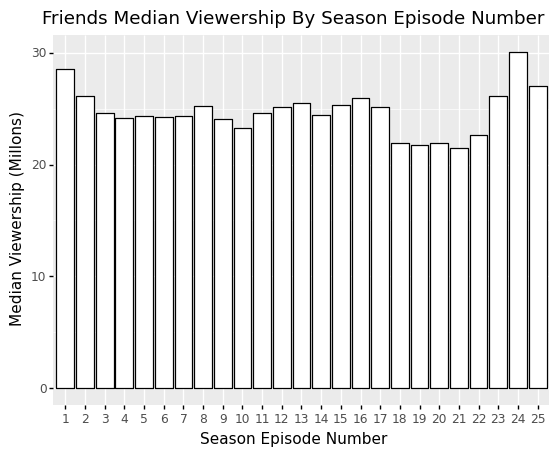

In [12]:
episode_median_viewership_plot = (ggplot(episode_median_viewership_summary, aes('factor(Episode)', 
                                                                                'Median_Viewership'))
                                  + geom_bar(stat = 'identity', fill = 'white', color = 'black')
                                  + labs(title = "Friends Median Viewership By Season Episode Number", 
                                         x = "Season Episode Number", y = "Median Viewership (Millons)",
                                         caption = "Viewership Data Drawn From Wikipedia (Nielsen Data)")
                                 )

print(episode_median_viewership_plot)

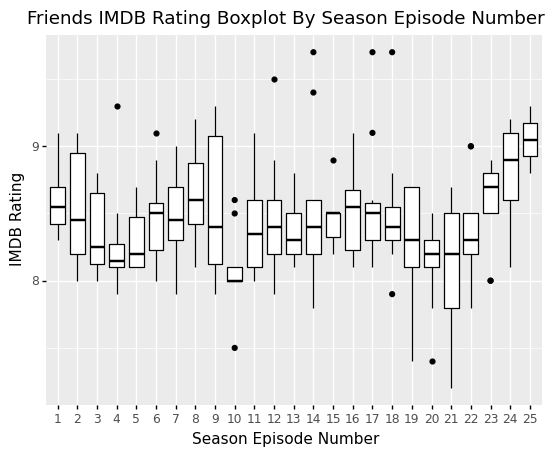

In [13]:
IMDB_rating_by_season_episode_number_boxplot = (ggplot(friends_database, aes('factor(Episode)', 'IMDB_Rating'))
                                  + geom_boxplot(fill = 'white', color = 'black')
                                  + labs(title = "Friends IMDB Rating Boxplot By Season Episode Number", 
                                         x = "Season Episode Number", 
                                         y = "IMDB Rating")
                                 )

print(IMDB_rating_by_season_episode_number_boxplot)

Similarly, the boxplot of IMDB data by season episode number shows season finales (Episodes 23-25) were generally the most critically acclaimed
among audiences, while Episodes 18-22 had a slight drop in median scores; this is consisent with the viewership finding for these episodes, and suggests that a possible explanation for the slight drop in viewership was the fact that those episodes (leading into the finale) were not as well received by audiences.

In seeing the lower viewership numbers, in the aggregate, for Episodes 18-22 of a season, I wanted to next examine whether this decline could also possibly be attributed to a seasonal effect (vs audience reception from the IMDB data).

As such, I calculated the median viewership total by month across all 10 seasons of Friends in the following table.

In [14]:
# Viewership for Median Episode By Month
month_median_viewership_summary = (friends_database >>
                                   group_by(X.Month) >>
                                   summarize(Median_Viewership = median(X.Viewers)))

print(month_median_viewership_summary)

   Month  Median_Viewership
0      1             25.820
1      2             25.080
2      3             23.650
3      4             21.910
4      5             25.900
5      9             27.740
6     10             24.405
7     11             24.430
8     12             23.240


This table shows the highest median viewership in September (the month of the season premiere), as well as May (the month of season finale) and January (the start of the calendar year). In turn, while there is a slight dip in median viewership in April (heading into the May finale), the difference is rather small. As such, this result further suggests that the fourth quarter dip in ratings could be due to a non-seasonal effect (such as show mechanics/audience reception), rather than a seasonal one. 

I next calculated the percentage change in viewership for all 236 episodes, and plotted these deltas
in a density plot.

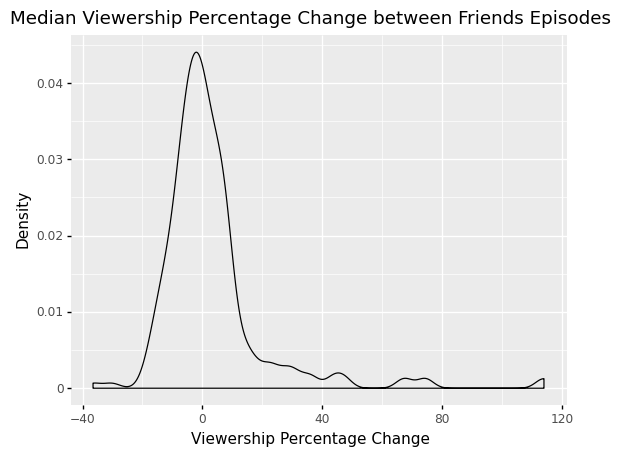

In [15]:
viewership_column_index = friends_database.columns.get_loc('Viewers')

episode_viewership_percentage_change = calculate_percentage_change(friends_database, "Individual_Episode", 
                                                                   viewership_column_index)

friends_database['Viewership_Percentage_Change'] = episode_viewership_percentage_change

viewership_change_density_plot = (ggplot(friends_database, aes('Viewership_Percentage_Change')) 
                                  + geom_density() 
                                  + labs(title = "Median Viewership Percentage Change between Friends Episodes", 
                                         x = "Viewership Percentage Change", y = "Density",
                                         caption = "Viewership Data Drawn From Wikipedia (Nielsen Data)"))
print(viewership_change_density_plot)

As shown above, the vast majority of deltas from episode to episode are centered around 0 (confirming prior results), with a very small portion of the distribution showing a greater than 20% decline episode to episode. The distribution is also right-skewed, indicating that Friends did have more significant increases in viewership episode to episode, rather than declines.

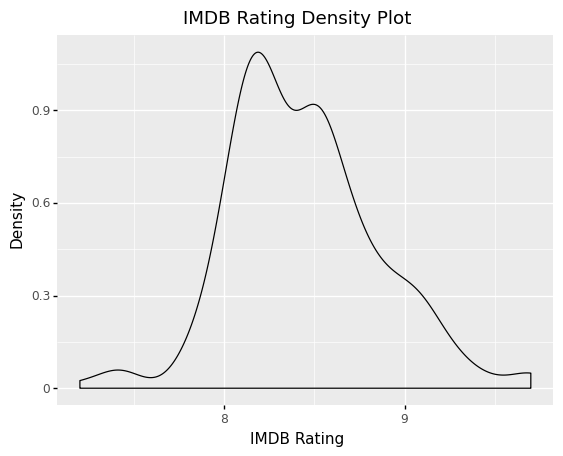

In [16]:
IMDB_rating_density_plot = (ggplot(friends_database, aes('IMDB_Rating')) 
                            + geom_density() 
                            + labs(title = "IMDB Rating Density Plot", 
                                   x = "IMDB Rating", y = "Density"))
print(IMDB_rating_density_plot)

I also calculated a density plot of IMDB scores across all 236 episodes. This density plot shows the modal IMDB Rating for an episode as being ~8.2; this density curve is also right skewed from the mode, indicating a larger number of episodes with even higher acclaim from audiences (IMDB Ratings of 9+) than less critically successful shows. 

After the analyses above, I next looked at the possible effect of director selection on Friends viewership totals and IMDB Ratings. 

In [17]:
friends_directors_summary_statistics = (friends_database >>
                                        group_by(X.Director) >>
                                        summarize(Episode_Count = n(X.Episode_Number), 
                                                  Median_Viewers = X.Viewers.median(), 
                                                  Median_IMDB_Rating = X.IMDB_Rating.median()) >>
                                        mask(X.Episode_Count >= 10) >>
                                        ungroup() >>
                                        arrange(X.Median_Viewers, ascending = False))
                                 
print(friends_directors_summary_statistics)

           Director  Episode_Count  Median_Viewers  Median_IMDB_Rating
15  Michael Lembeck             24          27.815                8.50
12  Kevin S. Bright             53          25.900                8.70
8      Gail Mancuso             14          25.825                8.35
5   David Schwimmer             10          24.095                8.50
18     Peter Bonerz             12          23.935                8.20
10    James Burrows             15          23.800                8.30
3         Ben Weiss             10          23.030                8.25
9    Gary Halvorson             54          22.615                8.30


As shown in the table above, 8 directors directed at least 10 solo episodes over the 236 episode show (Kevin S. Bright and Gary Halvorson also directed one episode jointly). Of these eight directors, Michael Lembeck achieved the highest median viewership in his 24 episodes, followed by Kevin Bright (who along with Marta Kaufmann and David Crane produced Friends). On the other hand, Gary Halvorson, who directed the most episodes of 55 (54 solo, 1 joint), interestingly had the lowest median viewership. In addition, while the margins between median IMDB ratings are very small, there appears to be at least a bit of a correlation between median viewership and median IMDB rating (i.e. audience reception moving lower with viewership and vice-versa by director).

I next performed a similar analysis for writers and writers' credits. 

In [18]:
friends_writers_summary_statistics = (friends_database >>
                                      select(X.Writer_1, X.Writer_2, X.Writer_3, X.Writer_4, X.Viewers, 
                                             X.IMDB_Rating, X.Episode_Number) >>
                                      gather('Writer_Position', 'Writer', ['Writer_1', 'Writer_2', \
                                                                           'Writer_3','Writer_4']) >>
                                      select(X.Writer, X.Viewers, X.IMDB_Rating, X.Episode_Number))

friends_writers_summary_statistics = friends_writers_summary_statistics[~pd.isna(friends_writers_summary_statistics.Writer)]

friends_writers_summary_statistics['Writer'] = friends_writers_summary_statistics['Writer'].astype("string")

friends_writers_summary_statistics = (friends_writers_summary_statistics >>
                                      group_by(X.Writer) >>
                                      summarize(Episode_Count = n(X.Episode_Number), 
                                                Median_Viewers = median(X.Viewers),
                                                Median_IMDB_Rating = median(X.IMDB_Rating)) >>
                                      mask(X.Episode_Count >= 10) >>
                                      ungroup() >>
                                      arrange(X.Median_Viewers, ascending = False))

print(friends_writers_summary_statistics)

                   Writer  Episode_Count  Median_Viewers  Median_IMDB_Rating
1             Alexa Junge             12          27.150                8.35
27         Marta Kauffman             21          26.820                8.60
13            David Crane             21          26.820                8.60
0              Adam Chase             16          26.120                8.35
19      Gregory S. Malins             17          25.100                8.50
48            Wil Calhoun             11          25.080                8.20
29         Michael Curtis             12          25.010                8.35
4            Andrew Reich             25          23.890                8.50
45              Ted Cohen             25          23.890                8.50
38          Scott Silveri             23          23.730                8.50
40           Seth Kurland             13          23.660                8.30
41  Shana Goldberg-Meehan             22          23.460                8.30

Of the sixteen writers with at least 10 writing (story + teleplay) credits during the 10-year show, Alexa Junge had the highest median viewership total for her 12 episodes (followed by show creators David Crane and Marta Kauffman). While there was a slight dip when median viewership was broken down by director, there was no such dip by writer. Furthermore, there is no evidence of correlation between median viewership and median IMDB rating by writer. Of note, show creators David Crane and Marta Kauffman had the highest median IMDB scores for their episodes from audiences. 


Finally, I wanted to examine all of the variables considered above together for their combined effect on viewership (a quantitative response variable). Since the goal of such analysis is inference rather than prediction, we can utilize a low-variance statistical learning/machine learning model like linear regression. As such, I created a linear regression model, regressing episode viewership across the 236 Friends episodes with Season Number, Episode Number, Director, the Month the episode originally aired, and whether series co-creators David Crane and Marta Kauffman served as writers (as the analysis above indicated that they had written for among the most watched episodes in the series, and critically acclaimed episodes by audiences.)

In [19]:
# David Crane/Marta Kaufmann Writing Credit Boolean
friends_writing_credit_boolean = (friends_database['Writer_1'] == "David Crane")

friends_database['Crane_Kauffman_Written_Episode'] = np.where(friends_writing_credit_boolean == True, 1, 0)

friends_linear_regression_features = (friends_database >>
                                     select(X.Season, X.Episode, X.Director, X.Viewers, 
                                            X.Crane_Kauffman_Written_Episode, X.Month))

# Regressing Episode Viewers on list of Features
friends_linear_regression_model = smf.ols(formula = 'Viewers ~ C(Season) + C(Episode) + C(Director) + C(Crane_Kauffman_Written_Episode) + C(Month)', data = friends_linear_regression_features)

friends_linear_regression_model_fit = friends_linear_regression_model.fit()

# Linear Regression Model Output
print(friends_linear_regression_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                Viewers   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     3.456
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           3.78e-11
Time:                        15:21:24   Log-Likelihood:                -617.44
No. Observations:                 236   AIC:                             1377.
Df Residuals:                     165   BIC:                             1623.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

The linear regression model summary, as shown above, indicates a statistically significant positive Season 2 effect (at a standard p-value of 0.05) as compared to Season 1 on viewership, while there is a statistically significant negative effect for Season 7 as compared to Season 1 (with no other seasons having statistically significant p-values). Taken together, the results could indicate that positive buzz from a successful first season, coupled with Friends' prominent feature in the post-Super Bowl timeslot, as well as the long sought-after Ross Rachel relationship by fans, all resulted in a significant positive Season 2 effect on viewership when compared to Season 1. Likewise, Season 7 had a significant negative effect; nevertheless, Season 6's coefficient was not quite statistically signficant, so one long hypothesized explanation for the Season 7 dip (i.e. Season 7's focus on Monica and Chandler's relationship) may not hold. Instead, Season 7 could possibly be explained as an inverse of Season 2, namely a seeming lack of focus on Ross and Rachel's relationship (which sits between Ross and Rachel's divorce in Season 6, and Ross and Rachel's pregnancy in Season 8).

In turn, episodes in the second and fourth quarters of the TV season (Episodes 6-12 and Episodes 18-24) largely had statistically significant negative coefficients/effects on viewership as compared to season premieres. Furthermore, while May, September, and October's effects on viewership as compared to January were positive, negative, negative, respectively, November, December, March and April's coefficients were not statistically significant. Taken together, this suggests that show mechanics/non-seasonal effects could better explain any dip in viewership, rather than a seasonal effect (such as any potential negative effect of the holidays Thanksgiving or Christmas on viewership). The second and fourth quarters for Friends could be when the writers and producers had to work on character/storyline development to set up a suprise in the middle of the season (such as Ross and Rachel's initial relationship in Season 2 Episode 14) or the end of the season (such as Ross's wedding to Emily, Chandler's proposal and wedding to Monica etc.). 

Finally, with the exception of a positive coefficient/effect for Director Peter Bonerz, the remaining director and writer credit coefficients were not statistically significant. However, one potential limitation of the model is that it represents only ~42% in the variation in viewership (adjusted R^2 value). More specifically, due to a limited number of features available in the Wikipedia dataset (which did not include features that reflect acting performances, elements from the scripts themselves or thematic focuses etc.), there is a lot of information toward understanding Friends viewership numbers that cannot be explained by the features above. Furthermore, director and writers credits do not capture the behind-the-scenes effect that a team of writers, producers and creators had on the show's success. At the same time, the model and analysis can be useful in possibly ruling out possible explanations, or coming up with new hypotheses that could be further explored in further analysis.


## IV: Summary

* Friends' viewership and audience reception (IMDB rating) was largely consistent both inter-season and intra-season
* There was a significant bounce in viewership in Season 2 after Season 1 (that cannot be explained by the post Super Bowl episodes alone)
* Viewership and audience reception was softer in the fourth quarter of the TV season heading into the season finale (which possibly could be explained by necessary character/storyline development ahead of a surprising/impactful finale)
* Director/Writing credits did not appear to impact ratings; a better possible explanation of Friends' ratings strength is the team of producers, writers and creators beyond the credits
* Cast performances undoubtedly had a significant impact on Friends' sustained success (and cannot be quantified in this dataset).